In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from itertools import combinations
from scipy.stats import mannwhitneyu
import warnings

In [2]:
warnings.simplefilter("ignore", FutureWarning)

In [3]:
spot_df_intconds = pd.read_csv(r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Spot stats 2025-09-07 conds-int.csv")
spot_df_strconds = pd.read_csv(r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Spot stats 2025-09-07 conds-str.csv")
track_df_intconds = pd.read_csv(r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Track stats 2025-09-07 conds-int.csv")
track_df_strconds = pd.read_csv(r"C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Track stats 2025-09-07 conds-str.csv")

In [4]:
def SwarmPlot(
        df: pd.DataFrame,                                     
        metric: str,
        *args,
        palette: str = 'tab10',

        show_swarm: bool = True,
        swarm_size: int = 1,
        swarm_outline_color: str = 'black',
        swarm_alpha: float = 0.5,

        show_violin: bool = True, 
        violin_fill_color: str = 'whitesmoke', 
        violin_edge_color: str = 'lightgrey', 
        violin_alpha: float = 0.5,
        violin_outline_width: float = 1,

        show_mean: bool = True,
        mean_span: float = 0.12,
        mean_color: str = 'black',
        show_median: bool = True,
        median_span: float = 0.08,
        median_color: str = 'black',
        line_width: float = 1,
        set_main_line: str = 'mean',

        show_error_bars: bool = True,
        errorbar_capsize: int = 4,
        errorbar_color: str = 'black',
        errorbar_lw: int = 1,
        errorbar_alpha: float = 0.5,

        show_mean_balls: bool = True,
        mean_ball_size: int = 5,
        mean_ball_outline_color: str = 'black',
        mean_ball_outline_width: float = 0.75,
        mean_ball_alpha: int = 1,
        show_median_balls: bool = False,
        median_ball_size: int = 5,
        median_ball_outline_color: str = 'black',
        median_ball_outline_width: float = 0.75,
        median_ball_alpha: int = 1,

        show_kde: bool = False,
        kde_inset_width: float = 0.5,
        kde_outline: float = 1,
        kde_alpha: float = 0.5,
        kde_legend: bool = False,
        kde_fill: bool = False,

        p_test: bool = False,

        show_legend: bool = True,
        show_grid: bool = False,
        open_spine: bool = True,

        # plot_width: int = 15,
        # plot_height: int = 9,
    ):


        """
        **Swarmplot plotting function.**

        ## Parameters:
            **df**:
            Track DataFrame;
            **metric**:
            Column name of the desired metric;
            **palette**:
            Qualitative color palette differentiating replicates (default: 'tab10');
            **show_swarm**:
            Show individual tracks as swarm points (default: True);
            **swarm_size**:
            Size of the swarm points (default: 5); *Swarm point size is automatically adjusted if the points are overcrowded*;
            **swarm_outline_color**:
            (default: 'black');
            **swarm_alpha**:
            Swarm points transparency (default: 0.5);
            **show_violin**:
            (default: True);
            **violin_fill_color**:
            (default: 'whitesmoke');
            **violin_edge_color**:
            (default: 'lightgrey');
            **violin_alpha**:
            Violins transparency (default: 0.5);
            **violin_outline_width**:
            (default: 1);
            **show_mean**:
            Show condition mean as a line (default: True);
            **mean_span**:
            Span length of the mean line (default: 0.12);
            **mean_color**:
            (default: 'black');
            **show_median**:
            Show condition median as a line (default: True);
            **median_span**:
            Span length of the median line (default: 0.08);
            **median_color**:
            (default: 'black');
            **line_width**:
            Line width of mean and median lines (default: 1);
            **set_main_line**:
            Set whether to show mean or median as a full line, while showing the other as a dashed line (default: 'mean');
            **show_error_bars**:
            Show standard deviation error bars around the mean (default: True);
            **errorbar_capsize**:
            Span length of the errorbar caps (default: 4);
            **errorbar_color**:
            (default: 'black');
            **errorbar_lw**:
            Line width of the error bars (default: 1);
            **errorbar_alpha**:
            Transparency of the error bars (default: 0.5);
            **show_mean_balls**:
            Show replicate means (default: True);
            **mean_ball_size**:
            (default: 5);
            **mean_ball_outline_color**:
            (default: 'black');
            **mean_ball_outline_width**:
            (default: 0.75);
            **mean_ball_alpha**:
            (default: 1);
            **show_median_balls**:
            Show replicate medians (default: False);
            **median_ball_size**:
            (default: 5);
            **median_ball_outline_color**:
            (default: 'black');
            **median_ball_outline_width**:
            (default: 0.75);
            **median_ball_alpha**:
            (default: 1);
            **show_kde**:
            Show inset KDE plotted next to each condition for each replicate (default: False);
            **kde_inset_width**:
            Height of the inset KDE (default: 0.5);
            **kde_outline**:
            Line width of the KDE outline (default: 1);
            **kde_alpha**:
            Transparency of the KDE (default: 0.5);
            **kde_legend**:
            Show legend for the KDE plots (default: False);
            **kde_fill**:
            Fill the KDE plots (default: False);
            **p_test**:
            Perform Mann-Whitney U test between all conditions and annotate the plot with the p-values (default: False);
            **show_legend**:
            Show legend (default: True);
            **show_grid**:
            Show grid (default: False);
            **open_spine**:
            Don't show the top and right axes spines (default: True);
        """




        plt.figure()
        

        df['Condition'] = df['Condition'].astype(str)
        conditions = df['Condition'].unique()


        if df['Replicate'].nunique() == 1:
            hue = 'Condition'
        else:
            hue = 'Replicate'

        if show_mean and show_median:
            if set_main_line == 'mean':
                mean_ls = '-'
                median_ls = '--'
            elif set_main_line == 'median':
                mean_ls = '--'
                median_ls = '-'
        if show_mean and not show_median:
            mean_ls = '-'
        if not show_mean and show_median:
            median_ls = '-'
        

        # ======================= KDE INSET =========================
        # If True, ensures spacing inbetween conditions for KDE plots
        if show_kde:


            # ----------- Create artificial and dirty x-axis positions for the KDE plots ------------

            spaced_conditions = ['spacer_0']

            for i, condition in enumerate(conditions):
                spaced_conditions.append(condition)

                if i < len(conditions) - 1:
                    spaced_conditions.append(f"spacer_{i+1}")

            df['Condition'] = pd.Categorical(df['Condition'], categories=spaced_conditions, ordered=True)
            
            
            # ----------------------- Swarm plot --------------------------

            if show_swarm:
                ax = plt.gca()
                size = int(swarm_size)

                while True:
                    ax.cla()  # clear so failed attempts don't stack markers
                    try:
                        with warnings.catch_warnings():
                            # treat UserWarnings from seaborn/matplotlib as exceptions
                            warnings.simplefilter("error", UserWarning)
                            sns.swarmplot(
                                data=df,
                                x="Condition",
                                y=metric,
                                hue=hue,
                                palette=palette,
                                size=size,
                                edgecolor=swarm_outline_color,
                                dodge=False,
                                alpha=swarm_alpha,
                                legend=False,
                                zorder=2,
                                ax=ax,
                            )
                        break  # SUCCESS at current size -> leave the loop

                    except UserWarning:
                        # still too crowded at this size
                        if size <= 0.1:
                            # Final attempt with size=-0.1 (as you requested), and suppress the warning
                            ax.cla()
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", UserWarning)
                                sns.swarmplot(
                                    data=df,
                                    x="Condition",
                                    y=metric,
                                    hue=hue,
                                    palette=palette,
                                    size=-0.09,
                                    edgecolor=swarm_outline_color,
                                    dodge=False,
                                    alpha=swarm_alpha,
                                    legend=False,
                                    zorder=2,
                                    ax=ax,
                                )
                            break  # done after final fallback
                        # otherwise, shrink and try again
                        size -= 0.1
                        
            

            # ------------------------ Violinplot -------------------------
            if show_violin:
                sns.violinplot(
                    data=df, 
                    x='Condition', 
                    y=metric, 
                    color=violin_fill_color, 
                    edgecolor=violin_edge_color, 
                    width=violin_outline_width, 
                    inner=None,
                    gap=0.1, 
                    alpha=violin_alpha, 
                    zorder=2, 
                    order=spaced_conditions
                    )
            

            # ------------------------ Scatterplot of replicate means ------------------------------

            
            if show_mean_balls:
                replicate_means = df.groupby(['Condition', 'Replicate'])[metric].mean().reset_index()
                sns.scatterplot(
                    data=replicate_means, 
                    x='Condition', 
                    y=metric, 
                    hue=hue, 
                    palette=palette, 
                    edgecolor=mean_ball_outline_color, 
                    s=mean_ball_size, 
                    legend=False, 
                    alpha=mean_ball_alpha, 
                    linewidth=mean_ball_outline_width, 
                    zorder=4
                    )
            if show_median_balls:
                replicate_medians = df.groupby(['Condition', 'Replicate'])[metric].median().reset_index()
                sns.scatterplot(
                    data=replicate_medians, 
                    x='Condition', 
                    y=metric, 
                    hue=hue, 
                    palette=palette, 
                    edgecolor=median_ball_outline_color, 
                    s=median_ball_size, 
                    legend=False, 
                    alpha=median_ball_alpha, 
                    linewidth=median_ball_outline_width, 
                    zorder=4
                    )
            

            # ---------------------------- Mean, Meadian and Error bars --------------------------------

            condition_stats = df.groupby('Condition')[metric].agg(['mean', 'median', 'std']).reset_index()

            cond_num_list = list(range(len(conditions)*2)) 
            for cond in cond_num_list:

                x_center = cond_num_list[cond]  # Get the x position for the condition

                if show_mean:
                    sns.lineplot(
                        x=[x_center - mean_span, x_center + mean_span],
                        y=[condition_stats['mean'].iloc[cond], condition_stats['mean'].iloc[cond]],
                        color=mean_color, 
                        linestyle=mean_ls, 
                        linewidth=line_width,
                        label='Mean' if cond == 0 else "", zorder=5
                        )
                    
                if show_median:
                    sns.lineplot(
                        x=[x_center - median_span, x_center + median_span],
                        y=[condition_stats['median'].iloc[cond], condition_stats['median'].iloc[cond]],
                        color=median_color, 
                        linestyle=median_ls, 
                        linewidth=line_width,
                        label='Median' if cond == 0 else "", zorder=5
                        )
                    
                if show_error_bars:
                    plt.errorbar(
                        x_center, 
                        condition_stats['mean'].iloc[cond], 
                        yerr=condition_stats['std'].iloc[cond], 
                        fmt='None',
                        color=errorbar_color, 
                        alpha=errorbar_alpha,
                        linewidth=errorbar_lw, 
                        capsize=errorbar_capsize, 
                        zorder=5, 
                        label='Mean ± SD' if cond == 0 else "",
                        )
                    

            # -------------------------------- P-tests -------------------------------------

            if p_test:

                real_conditions = [cond for cond in spaced_conditions if not cond.startswith('spacer')]
                pos_mapping = {cat: idx for idx, cat in enumerate(spaced_conditions)}
            
                y_max = df[metric].max()
                y_offset = y_max * 0.1

                for i, (cond1, cond2) in enumerate(combinations(real_conditions, 2)):
                    data1 = df[df['Condition'] == cond1][metric]
                    data2 = df[df['Condition'] == cond2][metric]
                    stat, p_value = mannwhitneyu(data1, data2)
                    x1, x2 = pos_mapping[cond1], pos_mapping[cond2]
                    y = y_max + y_offset * (i + 1)
                    plt.plot([x1, x1, x2, x2],
                            [y+4.5, y + y_offset / 2.5, y + y_offset / 2.5, y+1.5],
                            lw=1, color='black')
                    plt.text((x1 + x2) / 2, y + y_offset / 2,
                            f'p = {round(p_value, 3):.3f}', ha='center', va='bottom', 
                            fontsize=10, color='black')
            


            # ------------------------ Dirty B.     ..ars ----------------------------
            # A dirty way to shift the x-axis positions and make room for the KDE plots

            dirty_b = list(range(-1, len(conditions)*2))
            for i in dirty_b:
                x_val = dirty_b[i]
                sns.lineplot(
                    x=x_val-0.5,
                    y=[condition_stats['median'].iloc[i]],
                    color='none', 
                    linewidth=0,
                    label="", 
                    zorder=0
                    )


            # ------------------------ KDE inset plots ----------------------------

            ax = plt.gca()
            y_ax_min, y_ax_max = ax.get_ylim()
            
            for cond in cond_num_list[::2]:
                group_df = df[df['Condition'] == conditions[cond // 2]]   # DataFrame group for a given condition

                y_max = group_df[metric].max()
                inset_height = y_ax_max * (y_max/y_ax_max) + abs(y_ax_min)   # height of the inset plot
                inset_y = y_ax_min   # y inset position

                x_val = cond_num_list[cond]  
                offset_x = 0

                inset_ax = ax.inset_axes([x_val - offset_x, inset_y, kde_inset_width, inset_height], transform=ax.transData, zorder=0, clip_on=True)
                
                sns.kdeplot(
                    data=group_df,
                    y=metric,
                    hue=hue,
                    fill=kde_fill,
                    alpha=kde_alpha,
                    lw=kde_outline,
                    palette=palette,
                    ax=inset_ax,
                    legend=kde_legend,
                    zorder=0,
                    clip=(y_ax_min, y_ax_max)
                    )
                
                inset_ax.invert_xaxis()
                inset_ax.set_xticks([])
                inset_ax.set_yticks([])
                inset_ax.set_xlabel('')
                inset_ax.set_ylabel('')
    
                sns.despine(ax=inset_ax, left=True, bottom=False, top=True, right=True)



            # ------------------------ X axis clean-up ----------------------------
            # Another dirty trick - removing the spacer labels from the x-axis

            plt.xticks(
                ticks=range(len(spaced_conditions)),
                labels=[lbl if not lbl.startswith("spacer") else "" for lbl in spaced_conditions]
                )
            # plt.yticks(ticks=np.arange(0, y_ax_max, step=25))




        # ======================= IF FALSE KDE INSET =========================
        
        if show_kde == False:

            # ------------------------------------------ Swarm plot -----------------------------------------------------------

            if show_swarm:
                ax = plt.gca()
                size = swarm_size

                while True:
                    ax.cla()  # clear so failed attempts don't stack markers
                    try:
                        with warnings.catch_warnings():
                            # treat UserWarnings from seaborn/matplotlib as exceptions
                            warnings.simplefilter("error", UserWarning)
                            sns.swarmplot(
                                data=df,
                                x="Condition",
                                y=metric,
                                hue=hue,
                                palette=palette,
                                size=size,
                                edgecolor=swarm_outline_color,
                                dodge=False,
                                alpha=swarm_alpha,
                                legend=False,
                                zorder=2,
                                ax=ax,
                            )
                        break  # SUCCESS at current size -> leave the loop

                    except UserWarning:
                        # still too crowded at this size
                        if size <= 0.1:
                            # Final attempt with size=-0.1 (as you requested), and suppress the warning
                            ax.cla()
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", UserWarning)
                                sns.swarmplot(
                                    data=df,
                                    x="Condition",
                                    y=metric,
                                    hue=hue,
                                    palette=palette,
                                    size=-0.09,
                                    edgecolor=swarm_outline_color,
                                    dodge=False,
                                    alpha=swarm_alpha,
                                    legend=False,
                                    zorder=2,
                                    ax=ax,
                                )
                            break  # done after final fallback
                        # otherwise, shrink and try again
                        size -= 0.1
                        



                # sns.swarmplot(
                #     data=df, 
                #     x='Condition', 
                #     y=metric, 
                #     hue=hue, 
                #     palette=palette, 
                #     size=swarm_size, 
                #     edgecolor=swarm_outline_color, 
                #     dodge=False, 
                #     alpha=swarm_alpha, 
                #     legend=False, 
                #     zorder=2
                # )
            

            # ----------------------------------- Scatterplot of replicate means ------------------------------------------------------

            if show_mean_balls:
                replicate_means = df.groupby(['Condition', 'Replicate'])[metric].mean().reset_index()
                sns.scatterplot(
                    data=replicate_means, 
                    x='Condition', 
                    y=metric, 
                    hue=hue, 
                    palette=palette, 
                    edgecolor=mean_ball_outline_color, 
                    s=mean_ball_size, 
                    legend=False, 
                    alpha=mean_ball_alpha, 
                    linewidth=mean_ball_outline_width, 
                    zorder=4
                    )
            if show_median_balls:
                replicate_medians = df.groupby(['Condition', 'Replicate'])[metric].median().reset_index()
                sns.scatterplot(
                    data=replicate_medians, 
                    x='Condition', 
                    y=metric, 
                    hue=hue, 
                    palette=palette, 
                    edgecolor=median_ball_outline_color, 
                    s=median_ball_size, 
                    legend=False, 
                    alpha=median_ball_alpha, 
                    linewidth=median_ball_outline_width, 
                    zorder=4
                    )


            # -------------------------------------------- Violin plot ---------------------------------------------------------

            if show_violin:
                sns.violinplot(
                    data=df, 
                    x='Condition', 
                    y=metric, 
                    color=violin_fill_color, 
                    edgecolor=violin_edge_color, 
                    width=violin_outline_width, 
                    inner=None,
                    gap=0.2, 
                    alpha=violin_alpha, 
                    zorder=1
                    )
            

            #  ------------------------------------ Mean, median and errorbar lines -------------------------------------------

            condition_stats = df.groupby('Condition')[metric].agg(['mean', 'median', 'std']).reset_index()
            for i, row in condition_stats.iterrows():
                x_center = i   # x coordinate
                if show_mean:
                    sns.lineplot(
                        x=[x_center - mean_span, x_center + mean_span], 
                        y=[row['mean'], row['mean']], 
                        color=mean_color, 
                        linestyle=mean_ls, 
                        linewidth=line_width, 
                        label='Mean' if i == 0 else "", 
                        zorder=4
                        )
                
                if show_median:
                    sns.lineplot(
                        x=[x_center - median_span, x_center + median_span], 
                        y=[row['median'], row['median']], 
                        color=median_color, 
                        linestyle=median_ls, 
                        linewidth=line_width, 
                        label='Median' if i == 0 else "", 
                        zorder=4
                        )
                
                if show_error_bars:
                    plt.errorbar(
                        x=x_center, 
                        y=row['mean'], 
                        yerr=row['std'], 
                        fmt='None',
                        color=errorbar_color, 
                        alpha=errorbar_alpha, 
                        linewidth=errorbar_lw, 
                        capsize=errorbar_capsize, 
                        zorder=5, 
                        label='Mean ± SD' if i == 0 else ""
                        )
                
            
            # ---------------------------------------- P-tests ------------------------------------------------------------

            if p_test:
                conditions = df['Condition'].unique()
                pairs = list(combinations(conditions, 2))
                y_max = df[metric].max()
                y_offset = (y_max * 0.1)  # Offset for p-value annotations
                for i, (cond1, cond2) in enumerate(pairs):
                    data1 = df[df['Condition'] == cond1][metric]
                    data2 = df[df['Condition'] == cond2][metric]
                    stat, p_value = mannwhitneyu(data1, data2)
                    
                    # Annotate the plot with the p-value
                    x1, x2 = conditions.tolist().index(cond1), conditions.tolist().index(cond2)
                    y = y_max + y_offset * (i + 1)
                    plt.plot([x1, x1, x2, x2], [y+4.5, y + y_offset / 2.5, y + y_offset / 2.5, y+1.5], lw=1, color='black')
                    plt.text((x1 + x2) / 2, y + y_offset / 2, f'p = {round(p_value, 3):.3f}', ha='center', va='bottom', fontsize=10, color='black')

            

        # ----------------------- Title settings ----------------------------

        if show_kde:
            if show_swarm & show_mean & show_median:
                title = f"Swarm Plot with Mean, Median and KDE for {metric}"
            elif show_swarm & show_mean & show_median == False:
                title = f"Swarm Plot with Mean and KDE for {metric}"
            elif show_swarm & show_mean == False & show_median:
                title = f"Swarm Plot with Median and KDE for {metric}"
            elif show_swarm == False:
                if show_violin & show_mean & show_median:
                    title = f"Violin Plot with Mean, Median and KDE for {metric}"
                elif show_violin & show_mean & show_median == False:
                    title = f"Violin Plot with Mean and KDE for {metric}"
                elif show_violin & show_mean == False & show_median:
                    title = f"Violin Plot with Median and KDE for {metric}"
        else:
            if show_swarm & show_mean & show_median:
                title = f"Swarm Plot with Mean and Median for {metric}"
            elif show_swarm & show_mean & show_median == False:
                title = f"Swarm Plot with Mean for {metric}"
            elif show_swarm & show_mean == False & show_median:
                title = f"Swarm Plot with Median for {metric}"
            elif show_swarm == False:
                if show_violin & show_mean & show_median:
                    title = f"Violin Plot with Mean and Median for {metric}"
                elif show_violin & show_mean & show_median == False:
                    title = f"Violin Plot with Mean for {metric}"
                elif show_violin & show_mean == False & show_median:
                    title = f"Violin Plot with Median for {metric}"


        plt.title(title)
        plt.xlabel("Condition")
        plt.ylabel(metric)

        # Add a legend
        if show_mean_balls:
            replicate_handle = mlines.Line2D([], [], marker='o', color='w', markerfacecolor=sns.color_palette('tab10')[0], markeredgecolor=mean_ball_outline_color, markersize=10, label='Replicate Means')
            handles, labels = plt.gca().get_legend_handles_labels()
            handles.insert(0, replicate_handle)
            labels.insert(0, 'Replicate Means')
        if show_median_balls:
            replicate_handle = mlines.Line2D([], [], marker='o', color='w', markerfacecolor=sns.color_palette('tab10')[0], markeredgecolor='black', markersize=10, label='Replicate Medians')
            handles, labels = plt.gca().get_legend_handles_labels()
            handles.insert(0, replicate_handle)
            labels.insert(0, 'Replicate Medians')
        
        if show_legend:
            plt.legend(handles=handles, labels=labels, title='Legend', title_fontsize='12', fontsize='10', loc='upper right', bbox_to_anchor=(1.15, 1), frameon=True)
        else:
            plt.legend().remove()
        
        sns.despine(top=open_spine, right=open_spine, bottom=False, left=False)
        plt.tick_params(axis='y', which='major', length=7, width=1.5, direction='out', color='black')
        plt.tick_params(axis='x', which='major', length=0)
        if show_grid:
            plt.grid(show_grid, axis='y', color='lightgrey', linewidth=1.5, alpha=0.2)
        else:
            plt.grid(False)

        # Only move legend if it exists
        if plt.gca().get_legend() is not None:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))

        # plt.tight_layout()

        # return plt.gcf()
        
        # plt.savefig("plot.svg", format='svg', bbox_inches='tight')
        return plt.show()

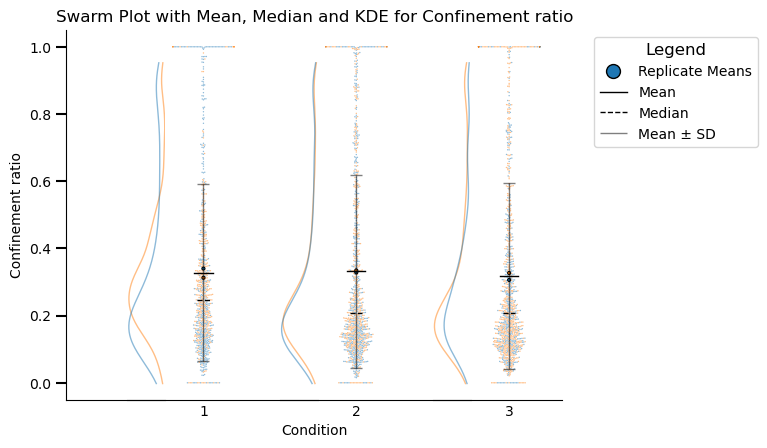

In [5]:
SwarmPlot(
    df=track_df_intconds,
    metric='Confinement ratio',
    show_kde=True,
    show_legend=True,
    show_violin=False,
    # plot_width=30
)

c:\Users\modri\miniconda3\envs\peregrin\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 17.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\modri\miniconda3\envs\peregrin\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\modri\miniconda3\envs\peregrin\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


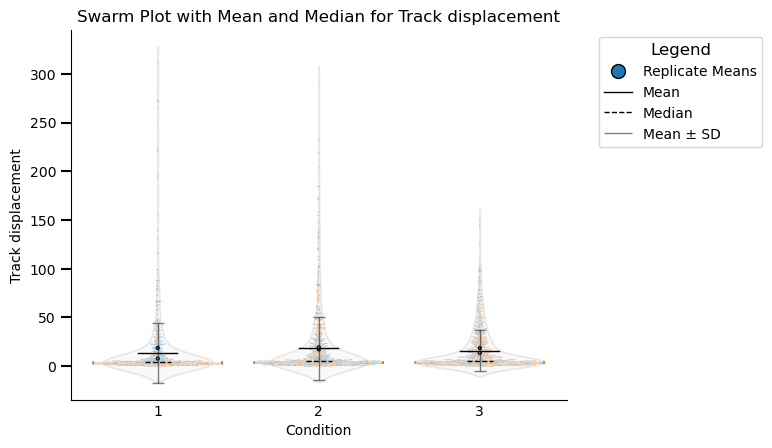

In [9]:
SwarmPlot(
    df=track_df_intconds,
    metric='Track displacement',
    show_legend=True
)

c:\Users\modri\miniconda3\envs\peregrin\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\modri\miniconda3\envs\peregrin\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\modri\miniconda3\envs\peregrin\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 32.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


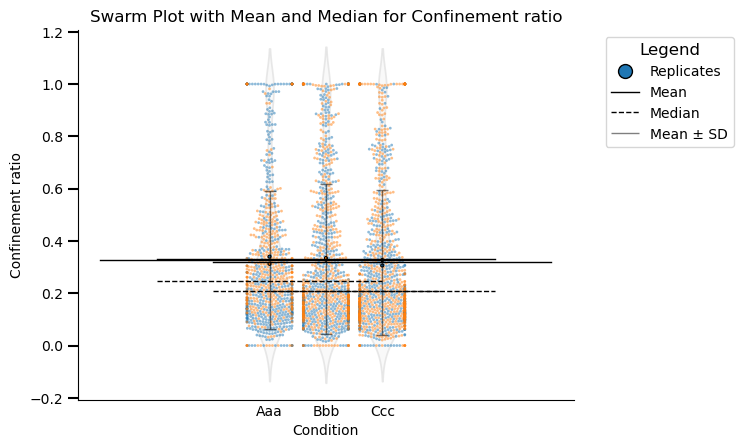

In [ ]:
SwarmPlot(
    df=track_df_strconds,
    metric='Confinement ratio',
    show_legend=True,
    # plot_width=30
)